# Lista de Exercícios 2 - Elementos de Processamento de Imagens

Prof. Gilson Antonio Giraldi \
Aluno Lorran de Araújo Durães Soares \
Questão 3

3 - Escolha uma base de imagens 𝐷 e converta as imagens para escala de cinza. Separe 𝐷 em dois subconjuntos disjuntos 𝐷𝑡𝑟 e 𝐷𝑡𝑒. 

(a) Calcule o ‘PCA para problemas com pequeno número de amostras’ sobre 𝐷𝑡𝑟. 

(b) Estude o espectro da matriz 𝑅=(1/𝑁)𝑋^TX para realizar a redução de dimensionalidade. 

(c) Aplique o PCA sobre 𝐷𝑡𝑒 e compare a eficiência de compressão com a DCT.

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
np.random.seed(42)
random.seed(42)
#from funcoes import PCAAnalysis
from scipy.fftpack import dct, idct

In [2]:
class PCAAnalysis:
    def __init__(self, data, labels=None, n_components=None):
        """
        Inicializa a classe com o conjunto de dados e o número de componentes desejados.
        
        Parâmetros:
            data (numpy.ndarray): Conjunto de dados com as observações nas linhas e variáveis nas colunas.
            n_components (int, opcional): Número de componentes principais. Se None, mantém todos.
        """
        self.data = data
        self.n_components = n_components
        self.labels = labels
        self.mean = None
        self.data_mean = None
        self.pca_base = None
        self.eigenvalues = None
        self.eigenvectors = None
        self.transformed_data = None

    def data_label(self, labels):
        self.labels = labels

    def def_ncomponents(self, n_components):
        self.n_components = n_components
        
    def truncate(self):
        """
        Reduz o número de componentes principais mantendo os dados truncados para n componentes.
        
        Parâmetros:
            n_components (int): Número de componentes a manter.
        
        Retorna:
            numpy.ndarray: Dados transformados com a quantidade de componentes truncada.
        """
        if self.eigenvectors is None:
             raise ValueError("O PCA ainda não foi ajustado. Execute o método 'fit()' antes.")
        
        if self.n_components is not None:
            matriz = np.zeros((len(self.data), len(self.data)))
            np.fill_diagonal(matriz[:self.n_components, :self.n_components], 1)
            P_PCA = np.dot(self.eigenvectors, matriz)
            self.pca_base = P_PCA
        
        self.transformed_data = np.dot(self.data_mean, self.pca_base)

        return self.transformed_data    

    def fit(self):
        """Realiza o ajuste PCA no conjunto de dados e transforma os dados para a nova base."""

        self.mean = np.mean(self.data, axis=0)
        self.data_mean = self.data - self.mean
        X = self.data_mean
        X_T = np.transpose(X)

        V = (1/len(self.data))*np.dot(X, X_T)

        autovalores, autovetoresV = np.linalg.eigh(V)
        autovetores = np.dot(X_T, autovetoresV)
        autovetores = autovetores / np.linalg.norm(autovetores, axis=0)
        ordem_decrescente = np.argsort(autovalores)[::-1]
        autovalores = autovalores[ordem_decrescente]
        autovetores = autovetores[:, ordem_decrescente]
        
        self.eigenvalues = autovalores
        self.eigenvectors = autovetores
        self.pca_base = autovetores
        self.truncate()

        return self.transformed_data
  
    def plot_primeira_component(self, coeficiente, comp, larg, num_images=3):
        """Plota resultado da media dos dados usando apenas uma dimensão do espaço"""

        coeficientes = [x * coeficiente for x in [-1,0,1]]
        #coeficientes = coeficiente*[-1, 0, 1]

        fig, axes = plt.subplots(1, 3, figsize=(12, 5))

        for i in range(num_images):
            imagem = self.mean + coeficientes[i] * np.sqrt(self.eigenvalues[0]) * self.eigenvectors[:, 0]
            axes[i].imshow(imagem.reshape(comp, larg), cmap='gray')
            axes[i].set_title(f'Coeficiente {i+1}')
            axes[i].axis('off')  

        plt.show()
    
    def plot_explained_variance(self, prop = 0.95):
        """Plota o espectro de variância explicada por cada componente principal."""

        if self.eigenvalues is None:
            raise ValueError("O PCA ainda não foi ajustado. Execute o método 'fit()' antes.")

        variancia_explicada = self.eigenvalues / np.sum(self.eigenvalues)
        variancia_explicada_acumulada = np.cumsum(variancia_explicada)

        self.n_components = np.argmax((variancia_explicada_acumulada) >= prop) + 1

        print(f"Número de componentes que representam {prop*100:.2f}% da variância dos dados: {self.n_components}")

        plt.figure(figsize=(10, 5))
        plt.bar(range(len(variancia_explicada)), variancia_explicada, alpha=0.6, label='Variância Explicada Individual')
        plt.step(range(len(variancia_explicada_acumulada)), variancia_explicada_acumulada, where='mid', color='red', label='Variância Explicada Acumulada')
        plt.xlabel('Número de Componentes Principais')
        plt.ylabel('Proporção da Variância Explicada')
        plt.title('Gráfico de Energia dos Autovalores (PCA)')
        plt.legend(loc='best')
        plt.show()


    def plot_pca_projection(self, dim1=0, dim2=1):
        """
        Plota os dados na base PCA em duas dimensões específicas.
        
        Parâmetros:
            dim1 (int): Índice da primeira dimensão a ser plotada.
            dim2 (int): Índice da segunda dimensão a ser plotada.
        """
        if self.transformed_data is None:
            raise ValueError("O PCA ainda não foi ajustado. Execute o método 'fit()' antes.")
        
        if self.labels is not None:
            colors=['blue','red', 'green', 'purple']
            legend =['Sério', 'Sorrindo']

            classes = np.unique(self.labels)

            plt.figure(figsize=(8, 6))

            for i, clas in enumerate(classes):
                
                class_0 = self.transformed_data[self.labels == clas]
                if clas == 0:
                    plt.scatter(class_0[:, dim1], class_0[:, dim2], color=colors[i], label=legend[0])
                else:
                    plt.scatter(class_0[:, dim1], class_0[:, dim2], color=colors[i], label=legend[1])
            
            plt.legend()
                
        else:    
            plt.scatter(self.transformed_data[:, dim1], self.transformed_data[:, dim2], alpha=0.7)
        
        plt.xlabel(f"Componente Principal {dim1 + 1}")
        plt.ylabel(f"Componente Principal {dim2 + 1}")
        plt.title("Projeção dos Dados na Base PCA")
        plt.grid(True)
        plt.show()

    
    def reconstrucion_images(self, data = None, data_transf = None):
        """Visualiza imagens no espaço original após truncamento"""

        if data_transf is None or data is None:
            data = self.data
            data_transf = self.transformed_data
            data_mean = self.mean
        else:
            data_mean = self.mean

        data_reconstructed = data_mean + np.dot(data_transf, np.transpose(self.pca_base))

        num_imagens = 4  

        fig, axes = plt.subplots(2, 4, figsize=(10, 8))  
        fig.subplots_adjust(hspace=0.3)  

        for i in range(num_imagens):
            
            axes[0, i].imshow(data_reconstructed[20*i].reshape(360, 260), cmap='gray')
            axes[0, i].set_title(f'Reconstruída {i+1}')
            axes[0, i].axis('off')  

            
            axes[1, i].imshow(data[20*i].reshape(360, 260), cmap='gray')
            axes[1, i].set_title(f'Original {i+1}')
            axes[1, i].axis('off')

        plt.show()
        return data_reconstructed

    def image_generator(self, n_principal_components, n_imagens):
    
        fig, axs = plt.subplots(1, n_imagens, figsize=(5 * n_imagens, 5))

        if n_imagens == 1:
            axs = [axs]

        for j in range(n_imagens):
        
            img = np.copy(self.mean)
        
            
            for i in range(n_principal_components):
                coeficiente = np.random.uniform(-1, 1)
                img += coeficiente * np.sqrt(self.eigenvalues[i]) * self.eigenvectors[:, i]

            im = axs[j].imshow(img.reshape(360, 260), cmap='gray')
            fig.colorbar(im, ax=axs[j], orientation='vertical')  
            axs[j].grid(False)

        plt.show()

    def transform(self, data):

        if self.pca_base is None:
            raise ValueError("O PCA ainda não foi ajustado. Execute o método 'fit()' antes.")            

        data_mean = data - self.mean

        data_transformed = np.dot(data_mean, self.pca_base)

        return data_transformed 


In [3]:
image_dir = './fei-database/'
images = []
image_paths = []

for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)
    img = img.resize((260, 360))  
    img_array = np.array(img)
    images.append(img_array)
    image_paths.append(img_path)  

images = np.array(images)
images.shape

(400, 360, 260, 3)

In [4]:
def pre_processamento(images):
    # deixa em tom de cinza
    images_preproces = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])

    # vetoriza
    images_preproces = images_preproces.reshape(images.shape[0], -1)

    # # normaliza
    # images_preproces = images_preproces / np.linalg.norm(images_preproces, axis=0)

    return images_preproces

In [5]:
images_preproces = pre_processamento(images)
images_preproces.shape

(400, 93600)

In [6]:
data_train, data_test = train_test_split(images_preproces, test_size=0.2, shuffle=True)

In [7]:
pca_small_size = PCAAnalysis(data_train)

In [8]:
pca_small_size.fit();

Número de componentes que representam 95.00% da variância dos dados: 99


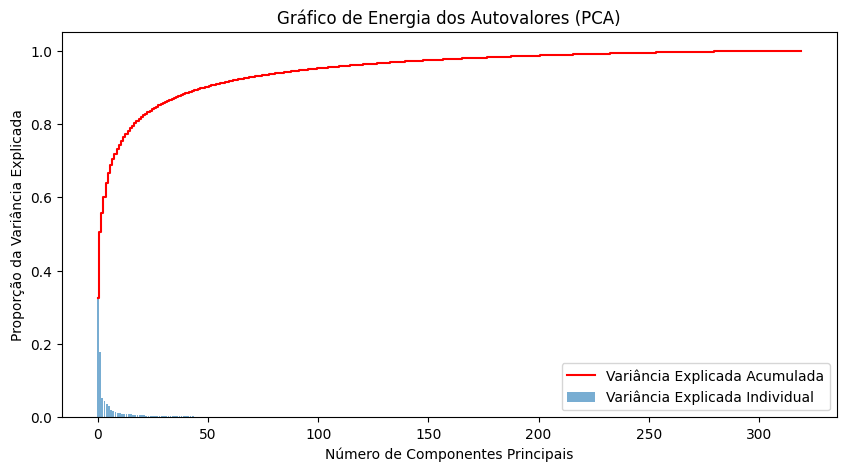

In [9]:
pca_small_size.plot_explained_variance(0.95)

In [10]:
pca_small_size.truncate();

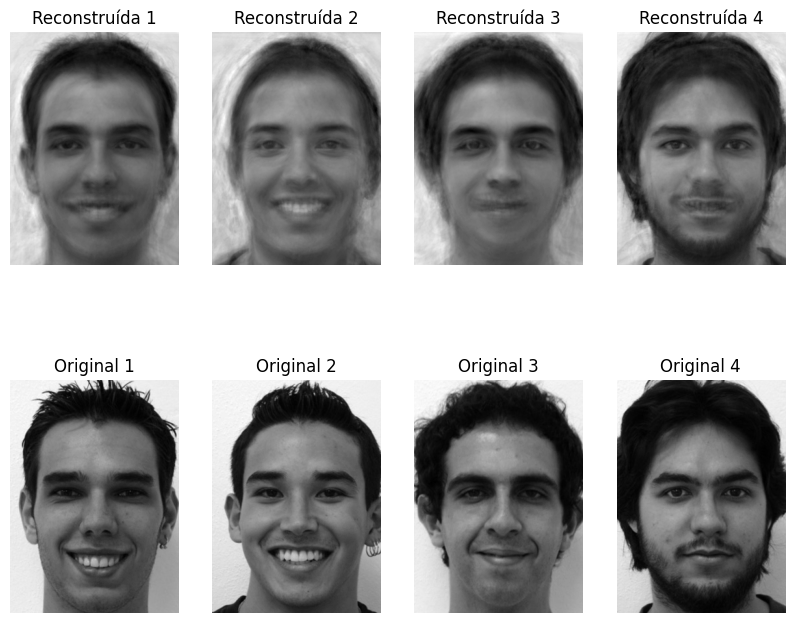

(80, 93600)

In [11]:
data_test_transformed = pca_small_size.transform(data_test)

data_test_reconstructed = pca_small_size.reconstrucion_images(data=data_test, data_transf=data_test_transformed)

data_test_reconstructed.shape

In [12]:
# Função para calcular a DCT
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

# Função para calcular a IDCT
def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

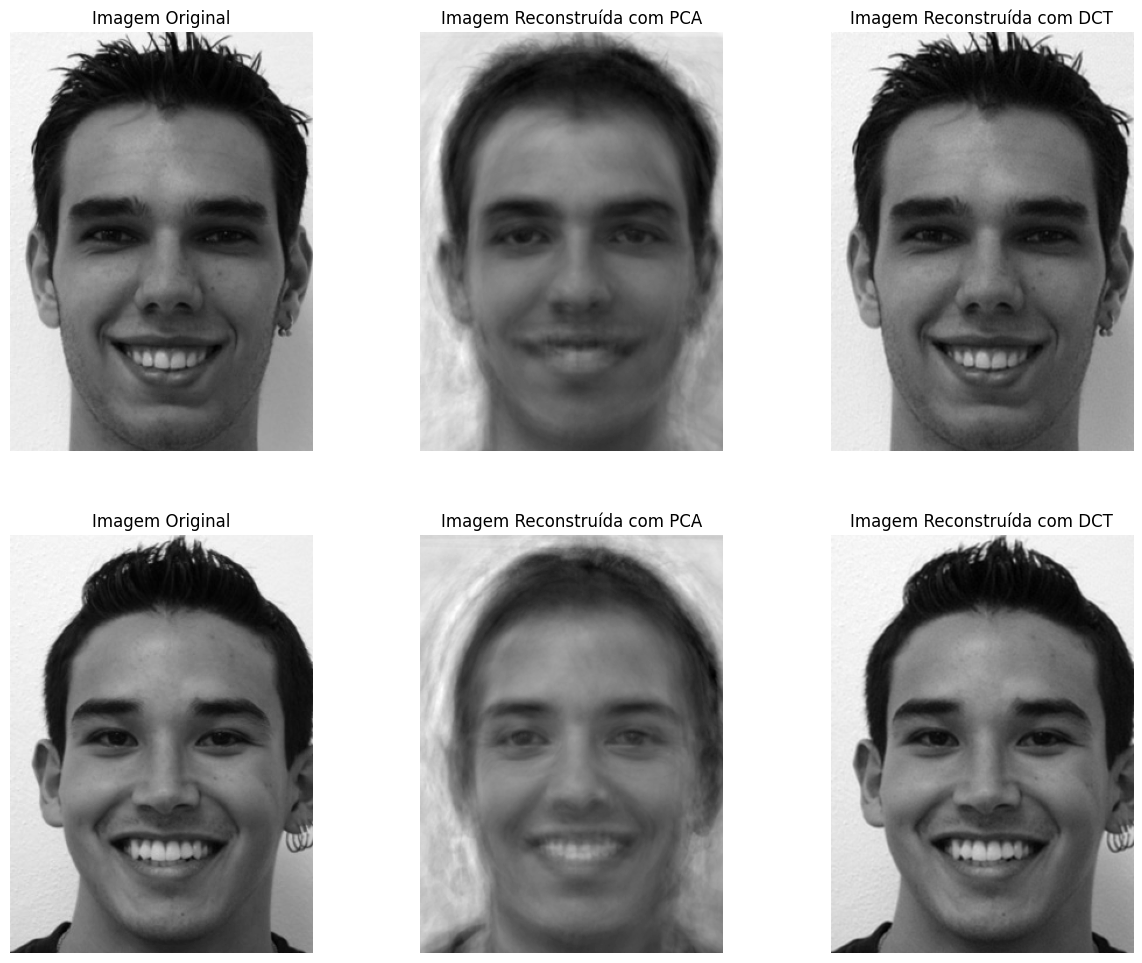

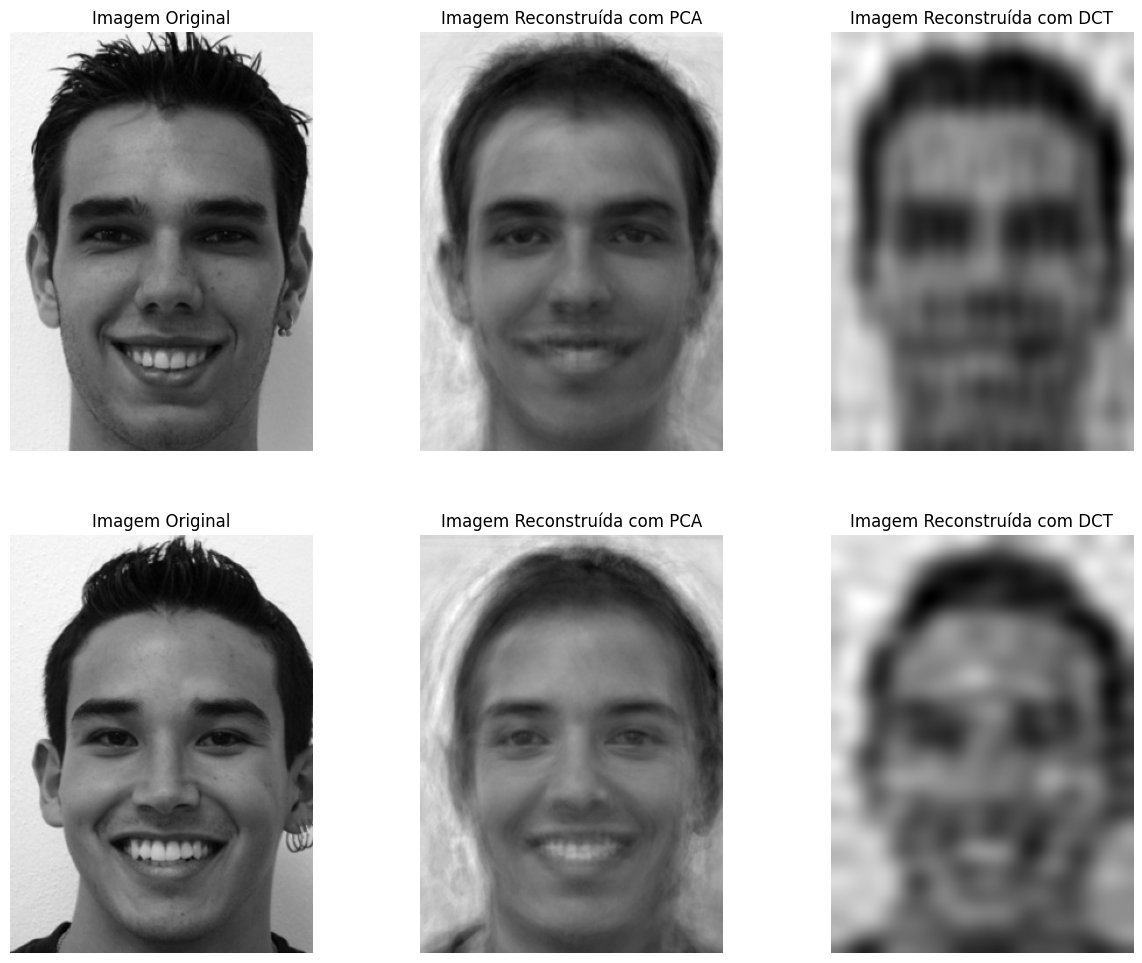

In [13]:
quant_images = 2

# define a taxa de compressão
compression_rate = [99/400, 99/93600]



for cr in compression_rate:

    # Exibindo as imagens original e comprimida
    plt.figure(figsize=(15, 25))

    for i in range(quant_images):
        
        image = data_test[20*i].reshape(360,260)

        # aplica a DCT em toda a imagem
        dct_transformed = dct2(image)

        # selecionando apenas as maiores frequências
        abs_dct = np.abs(dct_transformed)

        # ordena os coeficientes absolutos em ordem decrescente
        sorted_coefficients = np.sort(abs_dct.flatten())[::-1]

        # calcula o limiar para manter alguma porcentagem das maiores frequências
        threshold = sorted_coefficients[int(cr * len(sorted_coefficients))]

        #  cria e aplica uma máscara para manter apenas os coeficientes maiores que o limiar
        mask = abs_dct >= threshold
        dct_compressed = np.where(mask, dct_transformed, 0)

        # reconstroi a imagem a partir dos coeficientes comprimidos usando IDCT
        reconstructed_image = idct2(dct_compressed)

        

        plt.subplot(4, 3, 3*i + 1)
        plt.imshow(image, cmap='gray')
        plt.title("Imagem Original")
        plt.axis("off")

        plt.subplot(4, 3, 3*i + 2)
        plt.imshow(data_test_reconstructed[20*i].reshape(360,260), cmap='gray')
        plt.title("Imagem Reconstruída com PCA")
        plt.axis("off")

        plt.subplot(4, 3, 3*i + 3)
        plt.imshow(reconstructed_image, cmap='gray')
        plt.title("Imagem Reconstruída com DCT")
        plt.axis("off")
        
    plt.show()